In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [7]:
# Read data
path = '../../../real_monica/data.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(46, 47), dtype=bool)

In [8]:
motion.shape

(6318, 48)

In [9]:
motion[:50, 1]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2])

In [10]:
contacts.shape

(6318, 2)

## Height-Force plots

In [11]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [12]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

# Dataset Preparation

In [13]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [14]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [15]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [16]:
def create_acceleration_com_dataset(dataset, footsteps, motion=None, debug=False):
    idx = 1
    inputs = []
    labels = []
    
    while idx < len(footsteps):
        if idx > 0:
            # Compute time difference footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            # Round velocity array
            dataset[footsteps[idx-1], 1:4] = np.around(dataset[footsteps[idx-1], 1:4], decimals=1)
            dataset[footsteps[idx], 1:4] = np.around(dataset[footsteps[idx], 1:4], decimals=1)
            
            if time_difference < 0.4:
                fl_rr_moving = contacts[footsteps[idx], 0]
                fr_rl_moving = contacts[footsteps[idx], 1]

                if fl_rr_moving == fr_rl_moving:
                    print("Invalid footstep")
                    idx += 1
                    continue

                # Rotation matrices
                R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 39:43])

                # Retrieve base poses in world frame
                prev_base = dataset[footsteps[idx-1], 16:19]
                curr_base = dataset[footsteps[idx], 16:19]

                # Compute base displacement
                world_displacement = curr_base - prev_base
                base_displacement = np.dot(R_curr.T, world_displacement)
                
                # Compute yaw displacement
                prev_yaw = yaw_from_quaternion(dataset[footsteps[idx-1], 39:43])
                curr_yaw = yaw_from_quaternion(dataset[footsteps[idx], 39:43])
                yaw = curr_yaw - prev_yaw
                
                #print(f"{dataset[footsteps[idx-2], 1]}->{dataset[footsteps[idx-1], 1]}->{dataset[footsteps[idx], 1]}. {dataset[footsteps[idx-2], 19]}->{dataset[footsteps[idx-1], 19]}->{dataset[footsteps[idx], 19]}")
                
                inputs.append(dataset[footsteps[idx-2], 1:2].tolist() +
                              dataset[footsteps[idx-1], 1:2].tolist() +
                              dataset[footsteps[idx], 1:2].tolist() +
                              dataset[footsteps[idx-2], 19:20].tolist() +
                              dataset[footsteps[idx-1], 19:20].tolist() +
                              [fl_rr_moving, fr_rl_moving])
            
                labels.append([dataset[footsteps[idx], 19]])
        idx += 1
                
    return np.array(inputs, dtype=object), np.array(labels, dtype=object)

# Stack datasets
X_velocity, Y_velocity = create_acceleration_com_dataset(motion, [x for x in range(len(motion))])
print(X_velocity.shape)
print(Y_velocity.shape)

(6314, 7)
(6314, 1)


In [17]:
%store X_velocity
%store Y_velocity

Stored 'X_velocity' (ndarray)
Stored 'Y_velocity' (ndarray)


In [18]:
X_velocity[0, :]

array([0.0, 0.1, 0.1, -0.0124955084175, 0.0841218605638, True, False],
      dtype=object)

In [19]:
X_velocity[0, :]

array([0.0, 0.1, 0.1, -0.0124955084175, 0.0841218605638, True, False],
      dtype=object)

In [20]:
dic = dict()
for x in range(len(X_velocity)):
    key = str(round(X_velocity[x, 4], 5)) + str(round(X_velocity[x, 2], 1))
    if key in dic:
        dic[key][0].append(Y_velocity[x, 0])
        dic[key][1].append(X_velocity[x, 0])
        dic[key][2].append(X_velocity[x, 1])
        dic[key][3].append(X_velocity[x, 2])
        dic[key][4].append(X_velocity[x, 3])
        dic[key][5].append(X_velocity[x, 4])
    else:
        dic[key] = [[Y_velocity[x, 0]], 
                    [X_velocity[x, 0]],
                    [X_velocity[x, 1]],
                    [X_velocity[x, 2]],
                    [X_velocity[x, 3]],
                    [X_velocity[x, 4]]]


In [21]:
#dic.keys()

In [22]:
dic["0.084120.1"]

[[0.115657001734], [0.0], [0.1], [0.1], [-0.0124955084175], [0.0841218605638]]

In [23]:
np.isclose(dic[key][5][0], 0.37, 0.01)

False

In [90]:
for key in dic.keys():
    #print(f"{key[:3]} -> {key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 4)}. Std: {np.round(np.std(dic[key][0]), 3)}.")
    #if float(key[:3]) == 0.9 and float(key[3:]) == 0.1:
    #print(dic[key][5][0])
    #np.isclose(dic[key][5][0], 0.37, 0.01)
    if np.isclose(dic[key][5][0], 0.37, 0.04) and float(key[-3:]) == 0.1:
        for x in range(len(dic[key][0])):
            print(f"{dic[key][1][x]}->{dic[key][2][x]}->{dic[key][3][x]}. {dic[key][4][x]}->{dic[key][5][x]}. GT velocity: {dic[key][0][x]}. ")

0.3->0.3->0.1. 0.289636522532->0.368853092194. GT velocity: 0.296496301889. 
0.3->0.3->0.1. 0.288910895586->0.358584702015. GT velocity: 0.271587014198. 
0.3->0.3->0.1. 0.314043909311->0.38248872757. GT velocity: 0.294997215271. 
0.3->0.3->0.1. 0.297186106443->0.377765864134. GT velocity: 0.275227695704. 
0.3->0.3->0.1. 0.311043381691->0.379665672779. GT velocity: 0.281497210264. 
0.3->0.3->0.1. 0.313394963741->0.376765847206. GT velocity: 0.275496333838. 
0.4->0.1->0.1. 0.497538805008->0.383391201496. GT velocity: 0.0476542599499. 
0.4->0.1->0.1. 0.537439763546->0.380705803633. GT velocity: 0.0953439101577. 
0.4->0.1->0.1. 0.513893723488->0.383071780205. GT velocity: 0.0330925062299. 
0.4->0.1->0.1. 0.523590862751->0.378888905048. GT velocity: 0.0696505084634. 
0.4->0.4->0.1. 0.073149561882->0.363188922405. GT velocity: 0.458254307508. 
0.5->0.1->0.1. 0.654743671417->0.380735695362. GT velocity: 0.0463831499219. 
0.5->0.1->0.1. 0.606607794762->0.376016050577. GT velocity: 0.0415928773

In [114]:
for key in dic.keys():
    for x in range(len(dic[key][0])):
        print(f"{key[:3]}->{key[3:]}. Disp: {np.round(dic[key][0][x], 6)}. CoM Vel: {np.round(dic[key][2][x], 3)}.")

0.0->0.1. Disp: 0.107552. CoM Vel: 0.1.
0.0->0.1. Disp: 0.105201. CoM Vel: 0.1.
0.0->0.1. Disp: 0.093945. CoM Vel: 0.1.
0.0->0.1. Disp: 0.115647. CoM Vel: 0.1.
0.0->0.1. Disp: 0.119891. CoM Vel: 0.1.
0.0->0.1. Disp: 0.093603. CoM Vel: 0.1.
0.0->0.1. Disp: 0.083809. CoM Vel: 0.1.
0.0->0.1. Disp: 0.078869. CoM Vel: 0.1.
0.0->0.1. Disp: 0.069268. CoM Vel: 0.1.
0.0->0.1. Disp: 0.091386. CoM Vel: 0.1.
0.0->0.1. Disp: 0.198167. CoM Vel: 0.1.
0.0->0.1. Disp: 0.229526. CoM Vel: 0.1.
0.0->0.1. Disp: 0.229677. CoM Vel: 0.1.
0.0->0.1. Disp: 0.041334. CoM Vel: 0.1.
0.0->0.1. Disp: 0.284838. CoM Vel: 0.1.
0.0->0.1. Disp: 0.295766. CoM Vel: 0.1.
0.0->0.1. Disp: 0.334871. CoM Vel: 0.1.
0.0->0.1. Disp: 0.334227. CoM Vel: 0.1.
0.0->0.1. Disp: 0.370067. CoM Vel: 0.1.
0.0->0.1. Disp: 0.286184. CoM Vel: 0.1.
0.1->0.1. Disp: 0.110849. CoM Vel: 0.1.
0.1->0.1. Disp: 0.088649. CoM Vel: 0.1.
0.1->0.1. Disp: 0.120362. CoM Vel: 0.1.
0.1->0.1. Disp: 0.05013. CoM Vel: 0.1.
0.1->0.1. Disp: 0.1288. CoM Vel: 0.1.
0.1

In [23]:
for key in dic.keys():
    print(f"{key[:3]}->{key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}.")

0.0->0.1. Mean: 0.009. Std: 0.017.
0.1->0.1. Mean: 0.022. Std: 0.013.
0.1->0.2. Mean: 0.035. Std: 0.009.
0.2->0.2. Mean: 0.052. Std: 0.013.
0.2->0.0. Mean: 0.028. Std: 0.023.
0.0->0.0. Mean: -0.004. Std: 0.013.
0.0->0.2. Mean: 0.018. Std: 0.019.
0.2->0.3. Mean: 0.062. Std: 0.011.
0.3->0.3. Mean: 0.083. Std: 0.012.
0.3->0.0. Mean: 0.048. Std: 0.036.
0.0->0.3. Mean: 0.029. Std: 0.029.
0.3->0.4. Mean: 0.087. Std: 0.013.
0.4->0.4. Mean: 0.113. Std: 0.014.
0.4->0.0. Mean: 0.069. Std: 0.04.
0.0->0.4. Mean: 0.036. Std: 0.04.
0.4->0.5. Mean: 0.112. Std: 0.014.
0.5->0.5. Mean: 0.146. Std: 0.015.
0.5->0.0. Mean: 0.088. Std: 0.048.
0.0->0.5. Mean: 0.044. Std: 0.042.
0.5->0.6. Mean: 0.143. Std: 0.013.
0.6->0.6. Mean: 0.177. Std: 0.018.
0.6->0.0. Mean: 0.099. Std: 0.06.
0.0->0.6. Mean: 0.053. Std: 0.052.
0.6->0.7. Mean: 0.175. Std: 0.016.
0.7->0.7. Mean: 0.207. Std: 0.02.
0.7->0.0. Mean: 0.129. Std: 0.061.
0.0->0.7. Mean: 0.053. Std: 0.057.
0.7->0.8. Mean: 0.197. Std: 0.017.
0.8->0.8. Mean: 0.239. 

In [81]:
#dic.keys()

0.3 -> 0.0. Mean: 0.244. Std: 0.079
0.3 -> 0.1. Mean: 0.254. Std: 0.034
0.3 -> 0.2. Mean: 0.264. Std: 0.021
0.3 -> 0.3. Mean: 0.301. Std: 0.064
0.3 -> 0.4. Mean: 0.305. Std: 0.02
0.3 -> 0.5. Mean: 0.33. Std: 0.024
0.3 -> 0.6. Mean: 0.36. Std: 0.03
0.3 -> 0.7. Mean: 0.356. Std: 0.04
0.3 -> 0.8. Mean: 0.381. Std: 0.043
0.3 -> 0.9. Mean: 0.415. Std: 0.056
0.3 -> 1.0. Mean: 0.476. Std: 0.057
0.3 -> 1.1. Mean: 0.479. Std: 0.06


<ErrorbarContainer object of 3 artists>

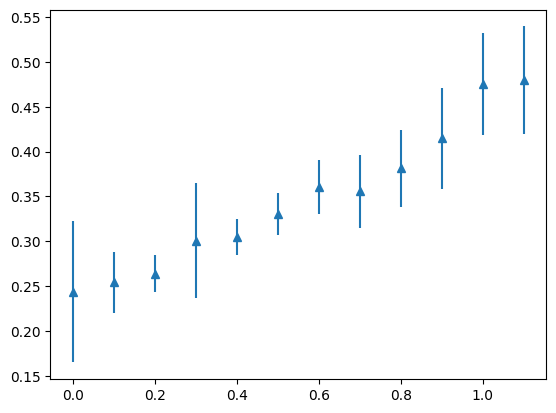

In [129]:
x, y, e = [], [], []

for vel in np.round(np.arange(0.0, 1.2, 0.1), 2):
    start = 0.3
    key = str(start)+str(vel)
    print(f"{start} -> {vel}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}")
    x.append(vel)
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')